<a href="https://colab.research.google.com/github/ziatdinovmax/SPM_ML_School_2021/blob/main/Day03/Notebooks/augGPBO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebooks compares Bayesian optimization with classical GP and with GP augmented by a structured probabilistic model. We are going to use a slightly modified version of the [Forester function](https://www.sfu.ca/~ssurjano/forretal08.html) that has local and global minima with the goal to identify the global minimum using the smallest number of steps.

*Prepared by Maxim Ziatdinov (August 2021)*

Install NumPyro (for [iterative No-U-Turn Sampler](https://github.com/pyro-ppl/numpyro/wiki/Iterative-NUTS))

In [ ]:
!pip install -q numpyro

Imports:

In [ ]:
from typing import Union, Dict, Type

from functools import partial

import jax.numpy as jnp
from jax import jit
import jax.random as jra
from jax.scipy import linalg as jLA
import jax
from jax.interpreters import xla

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_median

import numpy as onp
import matplotlib.pyplot as plt

numpyro.enable_x64()

### GP class and utility functions

Define common kernel functions:

In [ ]:
def _sqrt(x, eps=1e-12):
    return jnp.sqrt(x + eps)

def add_jitter(x, jitter=1e-6):
    return x + jitter

def square_scaled_distance(X: jnp.ndarray, Z: jnp.ndarray,
                           lengthscale: Union[jnp.ndarray, float] = 1.
                           ) -> jnp.ndarray:
    scaled_X = X / lengthscale
    scaled_Z = Z / lengthscale
    X2 = (scaled_X ** 2).sum(1, keepdims=True)
    Z2 = (scaled_Z ** 2).sum(1, keepdims=True)
    XZ = jnp.matmul(scaled_X, scaled_Z.T)
    r2 = X2 - 2 * XZ + Z2.T
    return r2.clip(0)

@jit
def RBFKernel(X: jnp.ndarray, Z: jnp.ndarray,
              params: Dict[str, jnp.ndarray],
              noise: int = 0, **kwargs: float) -> jnp.ndarray:
    r2 = square_scaled_distance(X, Z, params["k_length"])
    k = params["k_scale"] * jnp.exp(-0.5 * r2)
    if X.shape == Z.shape:
        k += add_jitter(noise, **kwargs) * jnp.eye(X.shape[0])
    return k


@jit
def MaternKernel(X: jnp.ndarray, Z: jnp.ndarray,
                 params: Dict[str, jnp.ndarray],
                 noise: int = 0, **kwargs: float) -> jnp.ndarray:
    r2 = square_scaled_distance(X, Z, params["k_length"])
    r = _sqrt(r2)
    sqrt5_r = 5**0.5 * r
    k = params["k_scale"] * (1 + sqrt5_r + (5/3) * r2) * jnp.exp(-sqrt5_r)
    if X.shape == Z.shape:
        k += add_jitter(noise, **kwargs) * jnp.eye(X.shape[0])
    return k

Define a base class for GP:

In [ ]:
class ExactGP:

    def __init__(self, input_dim, kernel, mean_fn=None):  # e.g. ExactGP(input_dim=2, kernel=RBFKernel)
        xla._xla_callable.cache_clear()
        self.input_dim = input_dim
        self.kernel = kernel
        self.mean_fn = mean_fn
        self.X_train = None
        self.y_train = None
        self.mcmc = None

    def model(self, X, y):
        """GP model"""
        # Initialize mean function at zeros
        f_loc = jnp.zeros(X.shape[0])
        # Sample kernel parameters and noise
        with numpyro.plate('k_param', self.input_dim):  # allows using ARD kernel for input_dim > 1
            length = numpyro.sample("k_length", dist.LogNormal(0.0, 1.0))
        scale = numpyro.sample("k_scale", dist.LogNormal(0.0, 1.0))
        noise = numpyro.sample("noise", dist.LogNormal(0.0, 1.0))
        # Add mean function (if any)
        if self.mean_fn is not None:
            f_loc += self.mean_fn(X).squeeze()
        # compute kernel
        k = self.kernel(
            X, X,
            {"k_length": length, "k_scale": scale},
            noise
        )
        # sample y according to the standard Gaussian process formula
        numpyro.sample(
            "y",
            dist.MultivariateNormal(loc=f_loc, covariance_matrix=k),
            obs=y,
        )

    def fit(self, rng_key, X, y,
            num_warmup=2000, num_samples=2000, num_chains=1,
            progress_bar=True, print_summary=True):
        """
        Run MCMC to infer the GP model parameters
        """
        self.X_train = X
        self.y_train = y

        init_strategy = numpyro.infer.init_to_median(num_samples=10)
        kernel = NUTS(self.model, init_strategy=init_strategy)
        self.mcmc = MCMC(
            kernel,
            num_warmup=num_warmup,
            num_samples=num_samples,
            num_chains=num_chains,
            progress_bar=progress_bar,
            jit_model_args=False
        )
        self.mcmc.run(rng_key, X, y)
        if print_summary:
            self.mcmc.print_summary()
    
    def get_samples(self, chain_dim=False):
        return self.mcmc.get_samples(group_by_chain=chain_dim)

    @partial(jit, static_argnames='self')
    def _predict(self, rng_key, X_test, params, **kwargs):
        """Prediction with a single sample of kernel hyperparameters"""
        noise = params["noise"]
        y_residual = self.y_train
        if self.mean_fn is not None:
            y_residual -= self.mean_fn(self.X_train, params).squeeze()
        # compute kernel matrices for train and test data
        k_pp = self.kernel(X_test, X_test, params, noise, **kwargs)
        k_pX = self.kernel(X_test, self.X_train, params, jitter=0.0)
        k_XX = self.kernel(self.X_train, self.X_train, params, noise, **kwargs)
        # compute the predictive covariance and mean
        K_xx_inv = jnp.linalg.inv(k_XX)
        K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
        y_mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, y_residual))
        if self.mean_fn is not None:
            y_mean += self.mean_fn(X_test, params).squeeze()
        # draw a sample from the posterior predictive for a given set of hyperparameters
        y_sample = (jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.0)) * 
                    jra.normal(rng_key, X_test.shape[:1])) + y_mean
        return y_mean, y_sample
    
    @partial(jit, static_argnames='self')
    def predict(self, rng_key, X_test, **kwargs):
        """Make prediction at X_test points using sampled GP hyperparameters"""
        samples = self.get_samples(chain_dim=False)
        num_samples = samples["k_length"].shape[0]
        # use vmap for 'vectorization'
        vmap_args = (jra.split(rng_key, num_samples), samples)
        predictive = jax.vmap(lambda params:
                        self._predict(params[0], X_test, params[1]))
        y_means, y_sampled = predictive(vmap_args)
        return y_means.mean(0), y_sampled

Define acquisition function for Bayesian optimization and active learning:

In [ ]:
def EI(rng_key: jnp.ndarray, model: Type[ExactGP],
       X: jnp.ndarray, xi: float = 0.01,
       maximize: bool = False) -> jnp.ndarray:
    """
    Expected Improvement
    """
    y_mean, y_sampled = model.predict(rng_key, X)
    mean, sigma = y_sampled.mean(0), y_sampled.std(0)
    u = (mean - y_mean.max() - xi) / sigma
    u = -u if not maximize else u
    normal = dist.Normal(jnp.zeros_like(u), jnp.ones_like(u))
    ucdf = normal.cdf(u)
    updf = jnp.exp(normal.log_prob(u))
    return sigma * (updf + u * ucdf) 


def UCB(rng_key: jnp.ndarray, model: Type[ExactGP],
        X: jnp.ndarray, beta: float = .25,
        maximize: bool = False) -> jnp.ndarray:
    """
    Upper confidence bound
    """
    _, y_sampled = model.predict(rng_key, X)
    mean, var= y_sampled.mean(0), y_sampled.var(0)
    delta = jnp.sqrt(beta * var)
    if maximize:
        return mean + delta
    return mean - delta 


def UE(rng_key: jnp.ndarray,
       model: Type[ExactGP],
       X: jnp.ndarray) -> jnp.ndarray:
    """Uncertainty-based exploration (aka kriging)"""
    _, y_sampled = model.predict(rng_key, X)
    return y_sampled.var(0)

## Objective function

Define our objective function:

In [ ]:
def forrester_func(x, params):
    return (params["A"] * x + params["x01"])**2 * jnp.sin(params["B"] * x + params["x02"])

def get_data(N=100, noise_level=0):
    onp.random.seed(1)
    X = jnp.linspace(0, 1, N)
    X_test = jnp.linspace(0, 1, N*2)
    truefunc = forrester_func(X, {"A": 5, "x01": -2, "B": 12, "x02": -4})
    Y = truefunc + noise_level * onp.random.normal(size=X.shape)
    return X[:, None], Y, truefunc, X_test[:, None]

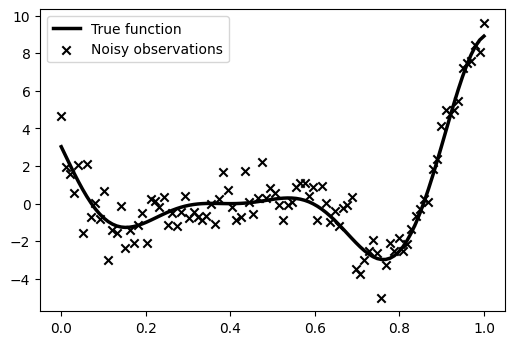

In [ ]:
plt.figure(dpi=100)
X, Y, truefunc, X_test = get_data(noise_level=1)
plt.scatter(X, Y, marker='x', c='k', zorder=0, label='Noisy observations')
plt.plot(X, truefunc, c='k', lw=2.5, zorder=1, label='True function')
plt.legend()

Do a standard GP (no optimization) on all the 'observed' data:

In [ ]:
rng_key, rng_key_predict = jra.split(jra.PRNGKey(0))

# initialize model
gp_model = ExactGP(1, RBFKernel)
# Obtain GP posterior
gp_model.fit(rng_key, X, Y, num_chains=1)
# Make a prediction
y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test)

sample: 100%|██████████| 4000/4000 [00:48<00:00, 83.15it/s, 5 steps of size 5.42e-01. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.13      0.02      0.13      0.09      0.16   1212.02      1.00
    k_scale     12.32      6.56     10.77      4.17     20.85   1142.15      1.00
      noise      0.85      0.13      0.84      0.64      1.04   1541.85      1.00

Number of divergences: 0


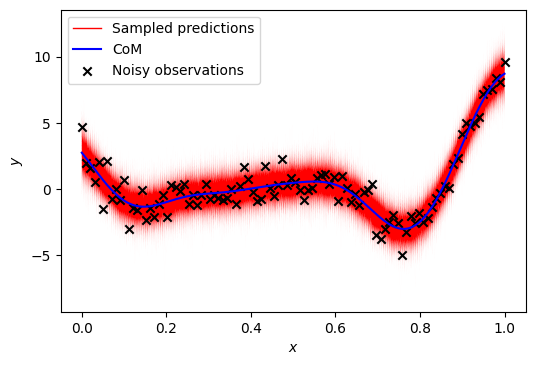

In [ ]:
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.scatter(X, Y, marker='x', c='k', zorder=2, label="Noisy observations")
for y1 in y_sampled:
    ax.plot(X_test, y1, lw=.02, zorder=1, c='r', alpha=.1)
l, = ax.plot(X_test, y_sampled[0], lw=1, zorder=0, c='r', alpha=1, label="Sampled predictions")
ax.plot(X_test, y_pred, lw=1.5, zorder=2, c='b', label='CoM')
ax.legend()
l.set_alpha(0)

## Bayesian Optimizations with Standard GP

Do standard Bayesian optimization:





In [ ]:
X, Y, truefunc, X_test = get_data(noise_level=1)

onp.random.seed(10)  #42
indices = jnp.arange(len(X))
idx = onp.random.randint(0, len(X), 2)
X_train, y_train = X[idx], Y[idx]
indices_train = indices[idx]
X_test = jnp.delete(X, idx)[:, None]
y_test = jnp.delete(Y, idx)
indices_test = jnp.delete(indices, idx)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2, 1) (98, 1) (2,) (98,)


1/12


sample: 100%|██████████| 4000/4000 [00:05<00:00, 783.25it/s, 7 steps of size 6.60e-01. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.64      2.04      1.00      0.05      3.50   1185.88      1.00
    k_scale      1.67      1.82      1.09      0.05      3.61   1703.27      1.00
      noise      1.72      1.70      1.22      0.17      3.50   1619.68      1.00

Number of divergences: 0


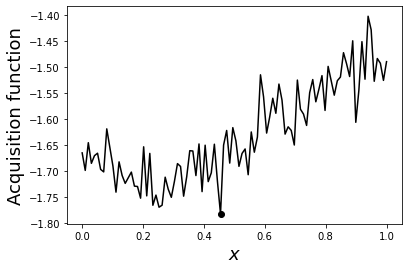

2/12


sample: 100%|██████████| 4000/4000 [00:05<00:00, 758.42it/s, 7 steps of size 8.23e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.64      1.99      1.04      0.07      3.53   1434.83      1.00
    k_scale      1.46      1.49      1.01      0.11      3.11   1532.87      1.00
      noise      1.49      1.55      1.07      0.22      2.93   1374.23      1.00

Number of divergences: 0


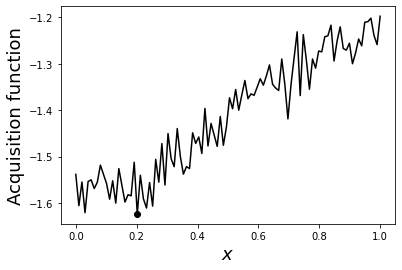

3/12


sample: 100%|██████████| 4000/4000 [00:05<00:00, 711.31it/s, 7 steps of size 8.51e-01. acc. prob=0.89] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.59      2.10      0.95      0.04      3.41   1520.29      1.00
    k_scale      1.69      1.69      1.18      0.12      3.48   1292.54      1.00
      noise      1.30      1.13      0.96      0.18      2.56   1618.23      1.00

Number of divergences: 0


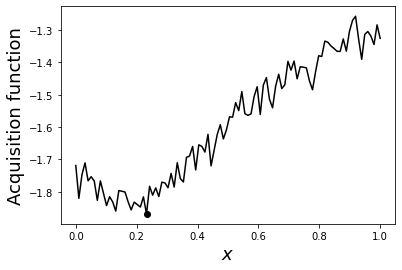

4/12


sample: 100%|██████████| 4000/4000 [00:06<00:00, 585.42it/s, 7 steps of size 7.54e-01. acc. prob=0.93] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.68      2.14      1.03      0.06      3.63   1349.77      1.00
    k_scale      1.50      1.53      1.03      0.07      3.20   1501.68      1.00
      noise      1.30      1.01      1.05      0.26      2.33   1421.40      1.00

Number of divergences: 0


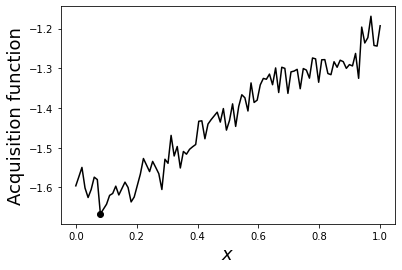

5/12


sample: 100%|██████████| 4000/4000 [00:05<00:00, 757.90it/s, 7 steps of size 7.15e-01. acc. prob=0.93] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.69      2.08      1.06      0.05      3.64   1392.60      1.00
    k_scale      1.39      1.54      0.92      0.11      3.02   1279.23      1.00
      noise      1.32      0.84      1.10      0.30      2.33   1309.67      1.00

Number of divergences: 0


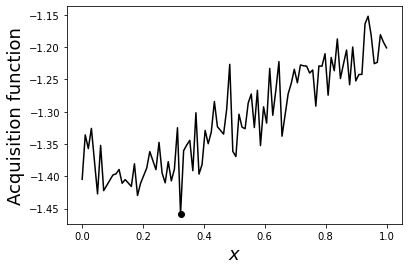

6/12


sample: 100%|██████████| 4000/4000 [00:05<00:00, 689.89it/s, 15 steps of size 8.76e-01. acc. prob=0.89]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.73      2.10      1.11      0.04      3.73   1551.90      1.00
    k_scale      1.36      1.43      0.92      0.11      2.84   1510.47      1.00
      noise      1.16      0.76      0.96      0.29      1.98   1793.97      1.00

Number of divergences: 0


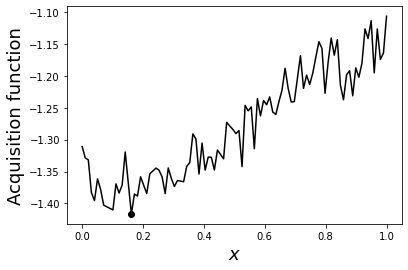

7/12


sample: 100%|██████████| 4000/4000 [00:05<00:00, 713.75it/s, 7 steps of size 8.82e-01. acc. prob=0.89]  



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.70      2.12      1.10      0.04      3.53   1456.84      1.00
    k_scale      1.41      1.47      0.95      0.12      2.93   1310.82      1.00
      noise      1.02      0.60      0.86      0.30      1.76   1761.91      1.00

Number of divergences: 0


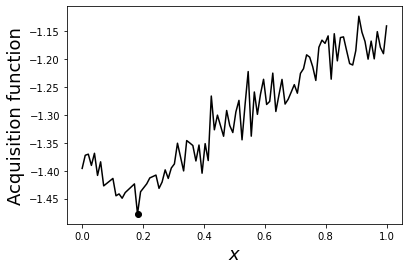

8/12


sample: 100%|██████████| 4000/4000 [00:06<00:00, 604.67it/s, 7 steps of size 6.78e-01. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.77      2.19      1.09      0.08      3.82   1202.90      1.00
    k_scale      1.37      1.41      0.92      0.07      2.90   1380.89      1.00
      noise      0.89      0.51      0.78      0.27      1.48   1590.17      1.00

Number of divergences: 0


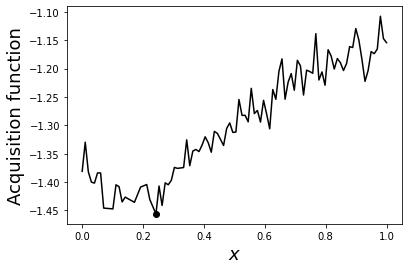

9/12


sample: 100%|██████████| 4000/4000 [00:05<00:00, 722.64it/s, 23 steps of size 8.70e-01. acc. prob=0.89]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.74      2.01      1.10      0.04      3.78   1509.84      1.00
    k_scale      1.34      1.46      0.89      0.11      2.96   1458.33      1.00
      noise      0.99      0.52      0.86      0.35      1.65   1882.70      1.00

Number of divergences: 0


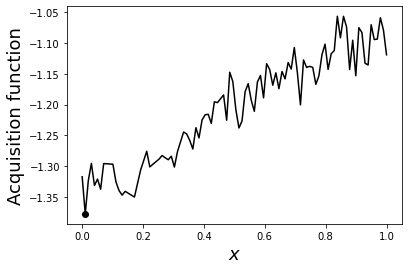

10/12


sample: 100%|██████████| 4000/4000 [00:05<00:00, 697.36it/s, 7 steps of size 5.12e-01. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.53      2.08      0.89      0.02      3.61   1061.28      1.00
    k_scale      1.20      1.28      0.81      0.05      2.57   1367.97      1.00
      noise      1.48      0.77      1.31      0.46      2.52   1143.65      1.00

Number of divergences: 0


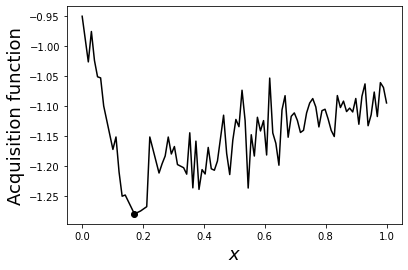

11/12


sample: 100%|██████████| 4000/4000 [00:06<00:00, 637.62it/s, 7 steps of size 4.42e-01. acc. prob=0.89] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.18      1.70      0.61      0.02      3.00   1199.85      1.00
    k_scale      1.44      1.69      0.94      0.06      2.97    786.41      1.00
      noise      1.34      0.71      1.24      0.21      2.26    514.16      1.00

Number of divergences: 0


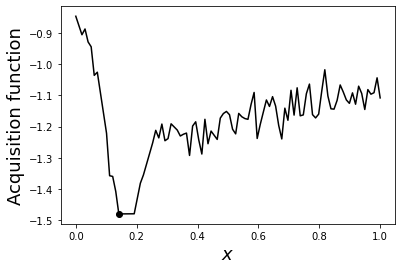

12/12


sample: 100%|██████████| 4000/4000 [00:05<00:00, 689.29it/s, 3 steps of size 6.45e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.35      1.76      0.77      0.03      3.14   1586.41      1.00
    k_scale      1.30      1.41      0.85      0.08      2.84    895.72      1.00
      noise      1.39      0.60      1.27      0.55      2.25   1306.01      1.00

Number of divergences: 0


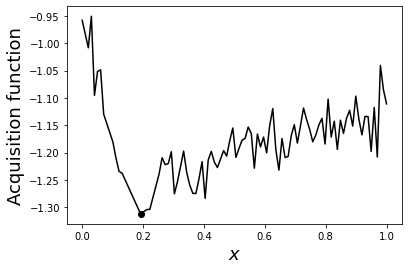

In [ ]:
def plot_result(x, obj, idx):
    plt.plot(x.squeeze(), obj, c='k')
    plt.scatter(x[idx], obj.min(), c='k')
    plt.xlabel("$x$", fontsize=18)
    plt.ylabel("Acquisition function", fontsize=18)
    plt.show()
    
exploration_steps = 12
acq_fn = UCB  #EI

rng_key, rng_key_predict = jra.split(jra.PRNGKey(0))

for e in range(exploration_steps):
    print("{}/{}".format(e+1, exploration_steps))
    # Initiate GP model
    gp_model = ExactGP(1, RBFKernel)
    # Get/update GP posterior
    gp_model.fit(rng_key, X_train, y_train, num_chains=1)
    # Compute acquisition 
    obj = acq_fn(rng_key_predict, gp_model, X_test)
    # Find maximum/minimum of acquisiton function to select the next "measurement" point
    next_point_idx = obj.argmax() if acq_fn == EI else obj.argmin()
    next_point = indices_test[next_point_idx]
    # Do "measurement"
    measured_point = y_test[next_point_idx]
    # Plot current result
    plot_result(X_test, obj, next_point_idx)
    # Append to the arrays of measured points
    X_train = jnp.append(X_train, X_test[next_point_idx][None], 0)
    X_test = jnp.delete(X_test, next_point_idx, 0)
    y_train = jnp.append(y_train, measured_point)
    y_test = jnp.delete(y_test, next_point_idx)
    indices_train = jnp.append(indices_train, next_point)
    indices_test = jnp.delete(indices_test, next_point_idx)

Plot results together with GP prediction on the final set of discovered points:

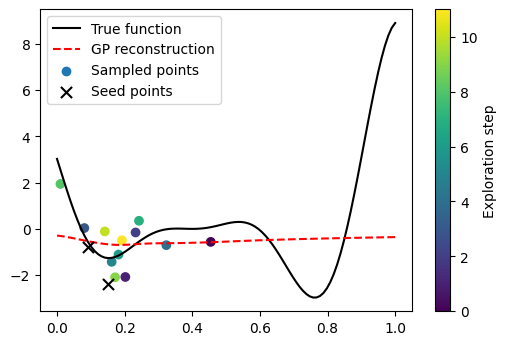

In [ ]:
def plot_final_result(X_train, y_train, y_pred):
    plt.figure(dpi=100)
    plt.scatter(X_train[2:], y_train[2:], c=jnp.arange(len(X_train[2:])),
                cmap='viridis', label="Sampled points", zorder=0)
    plt.colorbar(label="Exploration step")
    plt.scatter(X_train[:2], y_train[:2], marker='x', s=64, c='k', label="Seed points", zorder=1)
    plt.plot(X, truefunc, c='k', label='True function', zorder=0)
    plt.plot(X, y_pred, '--', c='red', label='GP reconstruction', zorder=0)
    plt.legend()
    plt.show()

y_pred, _ = gp_model.predict(rng_key_predict, X)
plot_final_result(X_train, y_train, y_pred)

## Bayesian Optimizations with GP augmented by probabilistic model

### Probabilistic model 1

Here we define our probabilistic model as a function with two inverted peaks. In another words, it is a very rough guess about the true form of our objective function. Nevertheless, as we show below, it will allow for a much more efficient Bayesian optimization.

We are going to write our GP models with probabilistic mean functions by subclassing the base GP class and redefining the model.

In [ ]:
def doubleLorentzfunc(x, params):
    return (params["y0"] - (params["A1"]/((x-params["x01"])**2+params["w1"]**2)**(1/2) +
            params["A2"]/((x-params["x02"])**2+params["w2"]**2)**(1/2)))

In [ ]:
class GP1(ExactGP):

    def __init__(self, input_dim, kernel, mean_fn):
        super(GP1, self).__init__(input_dim, kernel, mean_fn)

    def model(self, X, y):

        # Mean function prameters
        y0 = numpyro.sample("y0", dist.Uniform(-10, 10))
        x01 = numpyro.sample("x01", dist.Uniform(0.1, 0.5))
        x02 = numpyro.sample("x02", dist.Uniform(0.5, 0.9))
        A1 = numpyro.sample("A1", dist.LogNormal(0, 1))
        A2 = numpyro.sample("A2", dist.LogNormal(0, 1))
        w1 = numpyro.sample("w1", dist.HalfNormal(.1))
        w2 = numpyro.sample("w2", dist.HalfNormal(.1))
            # kernel parameters
        with numpyro.plate('k_param', self.input_dim):
            length = numpyro.sample("k_length", dist.LogNormal(0.0, 1))
        scale = numpyro.sample("k_scale", dist.LogNormal(0.0, 1))
        noise = numpyro.sample("noise", dist.LogNormal(0.0, 1))
        # compute mean function
        mean_fn_params = {"y0": y0, "x01": x01, "x02": x02,
                          "A1": A1, "A2": A2, "w1": w1, "w2": w2}
        
        f_loc = self.mean_fn(X, mean_fn_params).squeeze()

        # compute kernel
        k = self.kernel(
            X, X,
            {"k_length": length, "k_scale": scale},
            noise
        )
        # sample y according to the standard gaussian process formula
        numpyro.sample(
            "y",
            dist.MultivariateNormal(loc=f_loc, covariance_matrix=k),
            obs=y,
        )

Do Bayesian optimization with GP augmented by a probabilsitic model of expected system's behavior:

In [ ]:
X, Y, truefunc, X_test = get_data(noise_level=1)

onp.random.seed(10)  #42
indices = jnp.arange(len(X))
idx = onp.random.randint(0, len(X), 2)
X_train, y_train = X[idx], Y[idx]
indices_train = indices[idx]
X_test = jnp.delete(X, idx)[:, None]
y_test = jnp.delete(Y, idx)
indices_test = jnp.delete(indices, idx)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2, 1) (98, 1) (2,) (98,)


1/12


sample: 100%|██████████| 4000/4000 [00:10<00:00, 378.14it/s, 31 steps of size 1.10e-01. acc. prob=0.95] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.96      0.71      0.76      0.05      2.01   1067.59      1.00
         A2      1.31      1.15      0.94      0.09      2.85   1119.65      1.00
k_length[0]      1.61      2.06      1.00      0.07      3.43   1689.74      1.00
    k_scale      1.63      2.07      1.01      0.02      3.46   1446.79      1.00
      noise      1.25      1.70      0.75      0.06      2.68   1365.97      1.00
         w1      0.09      0.06      0.08      0.00      0.17   1761.89      1.00
         w2      0.08      0.06      0.07      0.00      0.16   2324.29      1.00
        x01      0.34      0.10      0.35      0.19      0.50   1503.17      1.00
        x02      0.70      0.12      0.70      0.52      0.88   2118.49      1.00
         y0      4.67      2.87      4.75      0.61      9.66    786.43      1.00

Number of divergences: 1


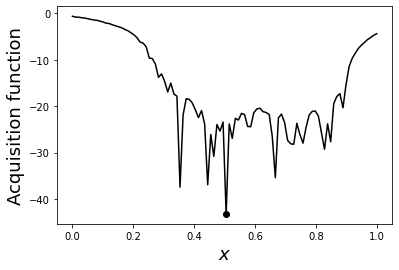

2/12


sample: 100%|██████████| 4000/4000 [00:10<00:00, 383.15it/s, 31 steps of size 1.57e-01. acc. prob=0.81] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.79      0.48      0.68      0.11      1.46    583.59      1.00
         A2      0.62      0.48      0.49      0.05      1.28    759.27      1.00
k_length[0]      1.84      2.61      1.06      0.02      4.18    668.95      1.00
    k_scale      1.60      1.99      1.00      0.05      3.48   1121.07      1.00
      noise      1.30      1.38      0.87      0.10      2.73   1168.11      1.00
         w1      0.09      0.05      0.09      0.00      0.17   1149.68      1.00
         w2      0.09      0.06      0.08      0.00      0.18   1458.05      1.00
        x01      0.22      0.06      0.22      0.12      0.30   1016.98      1.00
        x02      0.76      0.10      0.77      0.61      0.90   1225.84      1.00
         y0      4.93      2.51      4.89      1.15      9.17    591.09      1.01

Number of divergences: 13


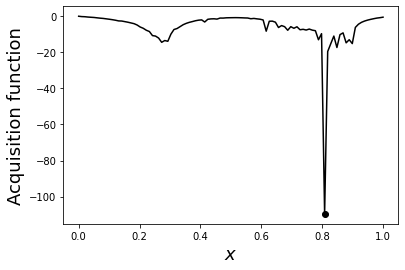

3/12


sample: 100%|██████████| 4000/4000 [00:11<00:00, 352.30it/s, 15 steps of size 1.00e-01. acc. prob=0.89] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.67      0.40      0.58      0.08      1.25    707.99      1.00
         A2      0.61      0.38      0.53      0.08      1.13    745.56      1.00
k_length[0]      1.70      2.07      1.05      0.03      3.71   1165.13      1.00
    k_scale      1.58      1.88      0.98      0.08      3.48    962.22      1.00
      noise      1.30      1.44      0.89      0.09      2.69   1006.93      1.00
         w1      0.09      0.05      0.09      0.00      0.17   1119.47      1.00
         w2      0.09      0.06      0.08      0.00      0.17   1095.63      1.00
        x01      0.22      0.06      0.22      0.11      0.30    877.93      1.00
        x02      0.80      0.07      0.80      0.70      0.90    869.83      1.00
         y0      4.15      2.45      4.00      0.41      8.43    544.82      1.00

Number of divergences: 16


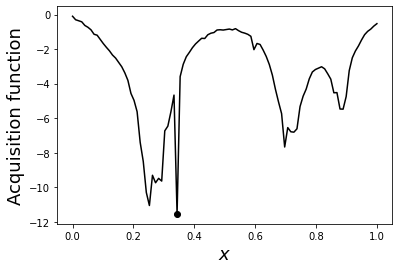

4/12


sample: 100%|██████████| 4000/4000 [00:10<00:00, 365.98it/s, 31 steps of size 1.36e-01. acc. prob=0.71] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.62      0.39      0.50      0.10      1.21    287.04      1.01
         A2      0.60      0.36      0.51      0.10      1.16    164.51      1.03
k_length[0]      1.82      2.05      1.08      0.05      4.61    209.55      1.01
    k_scale      1.44      1.59      0.96      0.04      3.21    779.85      1.00
      noise      0.99      1.10      0.68      0.06      1.95    558.45      1.00
         w1      0.10      0.05      0.10      0.02      0.19    497.72      1.00
         w2      0.09      0.05      0.08      0.00      0.16    651.45      1.01
        x01      0.20      0.05      0.20      0.12      0.25    758.61      1.00
        x02      0.80      0.07      0.80      0.71      0.90    533.20      1.00
         y0      3.80      2.33      3.59      0.66      8.60    162.79      1.02

Number of divergences: 96


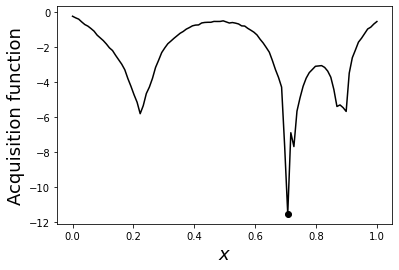

5/12


sample: 100%|██████████| 4000/4000 [00:11<00:00, 341.15it/s, 31 steps of size 1.27e-01. acc. prob=0.77] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.58      0.39      0.48      0.04      1.13    313.36      1.00
         A2      0.68      0.40      0.59      0.12      1.29    342.99      1.00
k_length[0]      1.71      2.48      1.01      0.04      3.84    653.33      1.00
    k_scale      1.54      1.66      1.06      0.08      3.24   1007.47      1.00
      noise      1.25      1.10      0.95      0.13      2.48    626.64      1.00
         w1      0.11      0.06      0.11      0.02      0.20    798.95      1.00
         w2      0.10      0.05      0.09      0.00      0.17    423.43      1.00
        x01      0.20      0.06      0.19      0.10      0.25    979.52      1.00
        x02      0.75      0.05      0.75      0.67      0.86   1044.32      1.00
         y0      3.75      2.63      3.49     -0.65      8.07    248.39      1.00

Number of divergences: 65


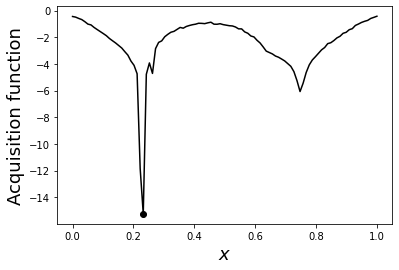

6/12


sample: 100%|██████████| 4000/4000 [00:11<00:00, 353.53it/s, 3 steps of size 1.92e-01. acc. prob=0.70]  



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.48      0.36      0.39      0.04      0.98    264.89      1.02
         A2      0.67      0.43      0.56      0.13      1.26    353.64      1.00
k_length[0]      1.75      2.63      1.06      0.04      3.70    778.10      1.00
    k_scale      1.52      1.69      0.98      0.04      3.34   1088.47      1.00
      noise      1.45      1.04      1.16      0.28      2.75    597.82      1.00
         w1      0.12      0.06      0.12      0.02      0.21    860.38      1.00
         w2      0.11      0.05      0.10      0.03      0.19    451.27      1.00
        x01      0.19      0.08      0.16      0.10      0.30    519.51      1.01
        x02      0.75      0.06      0.75      0.67      0.87    652.96      1.00
         y0      3.24      2.29      3.08     -0.29      7.12    249.53      1.01

Number of divergences: 42


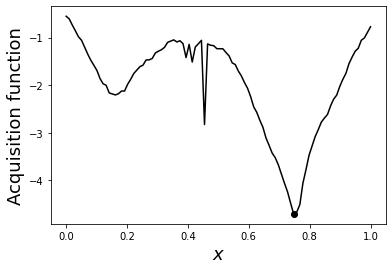

7/12


sample: 100%|██████████| 4000/4000 [00:11<00:00, 344.18it/s, 31 steps of size 1.16e-01. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.46      0.33      0.38      0.06      0.94    702.14      1.00
         A2      0.72      0.44      0.62      0.11      1.33    767.55      1.00
k_length[0]      1.67      2.10      1.05      0.05      3.74   1533.61      1.00
    k_scale      1.60      2.12      0.97      0.07      3.34    759.97      1.00
      noise      1.34      0.92      1.08      0.33      2.50   1005.38      1.00
         w1      0.12      0.06      0.12      0.02      0.21   1024.51      1.00
         w2      0.12      0.05      0.11      0.04      0.20   1232.35      1.00
        x01      0.18      0.07      0.16      0.10      0.29   1093.05      1.00
        x02      0.75      0.06      0.75      0.67      0.88    770.30      1.00
         y0      3.19      2.38      2.95     -0.80      7.01    572.60      1.00

Number of divergences: 1


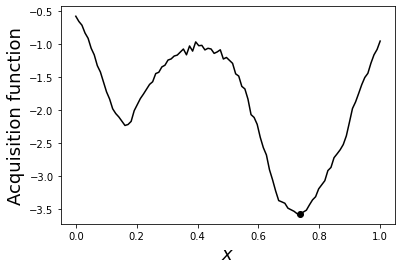

8/12


sample: 100%|██████████| 4000/4000 [00:11<00:00, 337.51it/s, 31 steps of size 1.74e-01. acc. prob=0.81] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.45      0.32      0.37      0.07      0.92    533.06      1.00
         A2      0.71      0.43      0.60      0.13      1.35    454.94      1.00
k_length[0]      1.72      2.26      1.06      0.03      3.77    899.97      1.00
    k_scale      1.55      1.70      1.01      0.03      3.36   1198.10      1.00
      noise      1.31      0.79      1.10      0.32      2.33    666.81      1.00
         w1      0.13      0.06      0.12      0.03      0.22    817.94      1.00
         w2      0.13      0.05      0.12      0.05      0.21   1003.82      1.00
        x01      0.18      0.08      0.16      0.10      0.29    566.11      1.00
        x02      0.76      0.07      0.75      0.66      0.88    977.49      1.00
         y0      3.03      2.32      2.81     -0.63      6.83    442.79      1.00

Number of divergences: 10


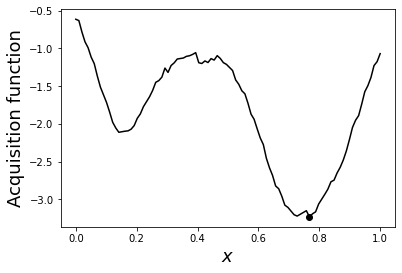

9/12


sample: 100%|██████████| 4000/4000 [00:11<00:00, 337.79it/s, 31 steps of size 1.59e-01. acc. prob=0.84] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.44      0.32      0.35      0.06      0.90    526.48      1.00
         A2      0.72      0.44      0.62      0.14      1.34    454.32      1.00
k_length[0]      1.61      1.93      1.01      0.04      3.40    798.47      1.00
    k_scale      1.56      1.77      1.02      0.06      3.29   1016.87      1.00
      noise      1.21      0.70      1.03      0.37      2.12    784.08      1.00
         w1      0.13      0.06      0.12      0.03      0.22    814.46      1.00
         w2      0.13      0.05      0.12      0.05      0.21    996.37      1.00
        x01      0.19      0.08      0.16      0.10      0.31    588.59      1.01
        x02      0.77      0.07      0.77      0.69      0.90    948.48      1.00
         y0      2.97      2.28      2.76     -0.81      6.60    361.76      1.00

Number of divergences: 8


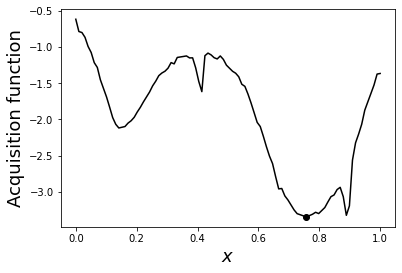

10/12


sample: 100%|██████████| 4000/4000 [00:11<00:00, 339.15it/s, 15 steps of size 1.63e-01. acc. prob=0.86] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.45      0.33      0.36      0.04      0.91    690.27      1.00
         A2      0.75      0.45      0.64      0.14      1.41    570.11      1.00
k_length[0]      1.61      1.92      0.99      0.07      3.70   1122.50      1.00
    k_scale      1.52      1.71      0.99      0.06      3.36   1318.74      1.00
      noise      1.50      0.78      1.32      0.44      2.51    871.23      1.00
         w1      0.13      0.06      0.12      0.03      0.22    662.94      1.00
         w2      0.12      0.05      0.11      0.05      0.20    813.39      1.00
        x01      0.19      0.08      0.16      0.10      0.30    909.13      1.00
        x02      0.78      0.06      0.77      0.71      0.90    720.60      1.00
         y0      3.08      2.31      2.89     -0.86      6.79    635.12      1.01

Number of divergences: 5


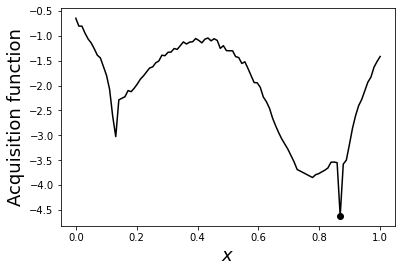

11/12


sample: 100%|██████████| 4000/4000 [00:12<00:00, 331.77it/s, 31 steps of size 1.29e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.55      0.39      0.45      0.05      1.10    652.53      1.00
         A2      0.68      0.39      0.59      0.14      1.27    683.48      1.00
k_length[0]      1.71      2.48      1.04      0.07      3.71   1048.74      1.00
    k_scale      1.56      1.82      0.99      0.06      3.41   1051.14      1.00
      noise      1.48      0.78      1.29      0.44      2.45   1096.89      1.00
         w1      0.13      0.06      0.13      0.04      0.22    892.65      1.00
         w2      0.10      0.04      0.10      0.03      0.17    886.84      1.00
        x01      0.18      0.07      0.16      0.10      0.28    955.18      1.00
        x02      0.74      0.04      0.74      0.67      0.80   1064.74      1.00
         y0      3.74      2.47      3.47      0.13      8.18    546.00      1.00

Number of divergences: 8


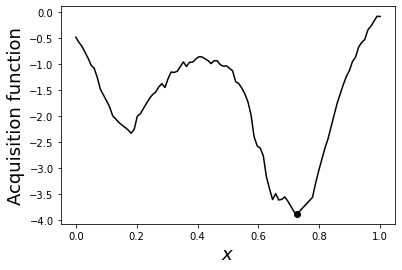

12/12


sample: 100%|██████████| 4000/4000 [00:12<00:00, 313.33it/s, 31 steps of size 1.26e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.56      0.38      0.45      0.05      1.09    575.38      1.00
         A2      0.70      0.43      0.60      0.15      1.30    238.41      1.00
k_length[0]      1.73      2.04      1.11      0.04      3.97   1343.26      1.00
    k_scale      1.51      1.89      0.96      0.08      3.14   1278.81      1.00
      noise      1.37      0.68      1.21      0.53      2.32    876.04      1.00
         w1      0.13      0.06      0.12      0.04      0.22   1346.99      1.00
         w2      0.11      0.04      0.10      0.04      0.17    599.80      1.00
        x01      0.18      0.07      0.16      0.10      0.28    908.52      1.00
        x02      0.74      0.04      0.75      0.68      0.80    962.05      1.00
         y0      3.83      2.45      3.62     -0.13      7.87    318.70      1.00

Number of divergences: 6


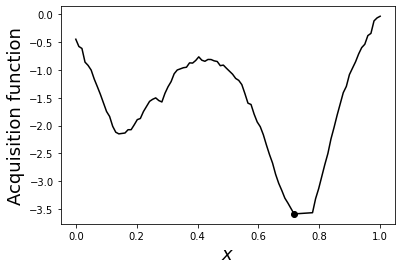

In [ ]:
exploration_steps = 12
acq_fn = UCB  #EI

rng_key, rng_key_predict = jra.split(jra.PRNGKey(0))

for e in range(exploration_steps):
    print("{}/{}".format(e+1, exploration_steps))
    # Initiate GP model
    gp_model = GP1(1, RBFKernel, mean_fn=doubleLorentzfunc)
    # Get/update GP posterior
    gp_model.fit(rng_key, X_train, y_train, num_chains=1)
    # Compute acquisition 
    obj = acq_fn(rng_key_predict, gp_model, X_test)
    # Find maximum/minimum of acquisiton function to select the next "measurement" point
    next_point_idx = obj.argmax() if acq_fn == EI else obj.argmin()
    next_point = indices_test[next_point_idx]
    # Do "measurement"
    measured_point = y_test[next_point_idx]
    # Plot current result
    plot_result(X_test, obj, next_point_idx)
    # Append to the arrays of measured points
    X_train = jnp.append(X_train, X_test[next_point_idx][None], 0)
    X_test = jnp.delete(X_test, next_point_idx, 0)
    y_train = jnp.append(y_train, measured_point)
    y_test = jnp.delete(y_test, next_point_idx)
    indices_train = jnp.append(indices_train, next_point)
    indices_test = jnp.delete(indices_test, next_point_idx)

Plot results together with GP prediction on the final set of discovered points:

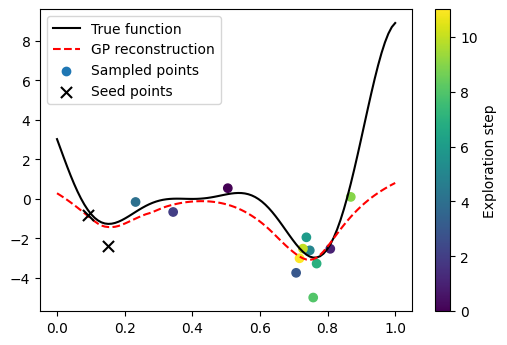

In [ ]:
y_pred, _ = gp_model.predict(rng_key_predict, X)

plot_final_result(X_train, y_train, y_pred)

### Probabilistic model 2

Here we will use a 'wrong' function that still partially captures some trends in data.

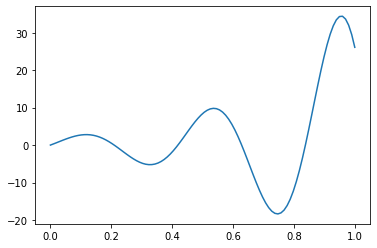

In [ ]:
def oscfunc(x, params):
    return params["A"] * jnp.exp(params["a"] * x) * jnp.sin(params["b"] * x)

x = jnp.linspace(0, 1, 100)
y = oscfunc(x, {"a": 3, "b": 15, "A": 2})
plt.plot(x, y)

In [ ]:
class GP2(ExactGP):

    def __init__(self, input_dim, kernel, mean_fn):
        super(GP2, self).__init__(input_dim, kernel, mean_fn)

    def model(self, X, y):

        # Mean function prameters
        a = numpyro.sample("a", dist.Normal(3, 2))
        b = numpyro.sample("b", dist.Normal(10, 5))
        A = numpyro.sample("A", dist.LogNormal(0, 1))
        # kernel parameters
        with numpyro.plate('k_param', self.input_dim):
            length = numpyro.sample("k_length", dist.LogNormal(0.0, 1))
        scale = numpyro.sample("k_scale", dist.LogNormal(0.0, 1))
        noise = numpyro.sample("noise", dist.LogNormal(0.0, 1))
        # compute mean function
        mean_fn_params = {"a": a, "b": b, "A": A}
        
        f_loc = self.mean_fn(X, mean_fn_params).squeeze()

        # compute kernel
        k = self.kernel(
            X, X,
            {"k_length": length, "k_scale": scale},
            noise
        )
        # sample y according to the standard gaussian process formula
        numpyro.sample(
            "y",
            dist.MultivariateNormal(loc=f_loc, covariance_matrix=k),
            obs=y,
        )

Run Bayesian optimization:

In [ ]:
X, Y, truefunc, X_test = get_data(noise_level=1)

onp.random.seed(10)  #42
indices = jnp.arange(len(X))
idx = onp.random.randint(0, len(X), 2)
X_train, y_train = X[idx], Y[idx]
indices_train = indices[idx]
X_test = jnp.delete(X, idx)[:, None]
y_test = jnp.delete(Y, idx)
indices_test = jnp.delete(indices, idx)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2, 1) (98, 1) (2,) (98,)


1/12


sample: 100%|██████████| 4000/4000 [00:06<00:00, 587.91it/s, 7 steps of size 5.38e-01. acc. prob=0.86] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.79      0.81      0.56      0.02      1.66    580.73      1.00
          a      2.63      1.97      2.65     -0.49      5.77   1983.02      1.00
          b      9.47      6.84      9.62     -2.71     19.78    792.87      1.00
k_length[0]      1.54      1.84      0.96      0.07      3.29   1669.07      1.00
    k_scale      2.04      2.25      1.35      0.09      4.43   1704.00      1.00
      noise      1.92      1.87      1.34      0.10      4.07   1560.14      1.00

Number of divergences: 13


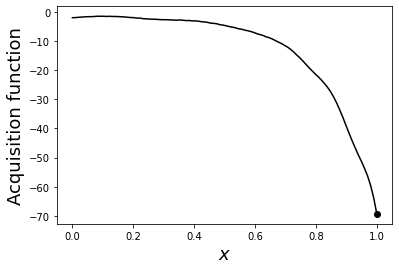

2/12


sample: 100%|██████████| 4000/4000 [00:07<00:00, 523.49it/s, 63 steps of size 7.33e-02. acc. prob=0.88] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      1.00      0.99      0.70      0.08      2.13    648.58      1.00
          a      3.06      0.98      3.08      1.53      4.65    517.51      1.00
          b      3.73      4.67      2.00      0.16     13.78      5.97      1.22
k_length[0]      1.44      1.61      0.91      0.03      3.27   1141.72      1.00
    k_scale      2.02      2.35      1.28      0.09      4.49    968.00      1.00
      noise      2.06      2.11      1.44      0.18      4.14    621.01      1.00

Number of divergences: 58


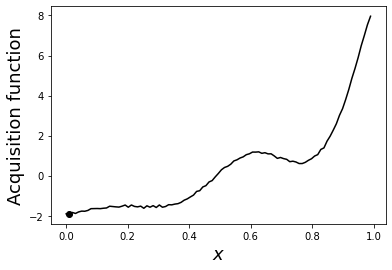

3/12


sample: 100%|██████████| 4000/4000 [00:07<00:00, 534.87it/s, 31 steps of size 1.14e-01. acc. prob=0.77] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.78      0.71      0.61      0.06      1.51    249.56      1.03
          a      3.34      0.99      3.30      1.76      4.89     57.43      1.04
          b      5.31      3.04      6.55      0.94      9.21      3.13      1.98
k_length[0]      1.41      1.86      0.77      0.05      3.45    413.57      1.01
    k_scale      1.31      1.62      0.85      0.06      2.83    439.36      1.01
      noise      3.59      2.34      3.09      0.65      6.83    565.63      1.01

Number of divergences: 119


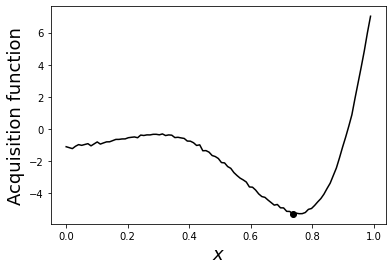

4/12


sample: 100%|██████████| 4000/4000 [00:07<00:00, 537.21it/s, 31 steps of size 1.61e-01. acc. prob=0.89] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.55      0.43      0.43      0.07      1.08    820.31      1.00
          a      3.16      0.81      3.15      1.92      4.57    730.90      1.00
          b      7.93      0.51      7.95      7.04      8.72   1044.57      1.00
k_length[0]      1.46      2.05      0.84      0.02      3.30   1291.55      1.00
    k_scale      1.50      1.79      0.91      0.05      3.26    734.09      1.00
      noise      3.55      2.45      2.91      0.20      6.48    773.09      1.00

Number of divergences: 0


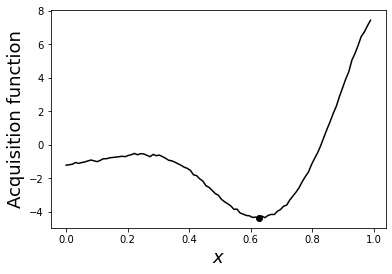

5/12


sample: 100%|██████████| 4000/4000 [00:07<00:00, 517.27it/s, 63 steps of size 7.91e-02. acc. prob=0.81]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.42      0.36      0.32      0.03      0.84    423.86      1.00
          a      3.30      1.02      3.37      2.01      4.95    338.78      1.00
          b      9.00      3.15      8.04      6.91     14.75      4.96      1.14
k_length[0]      1.31      1.57      0.83      0.03      2.83    760.29      1.00
    k_scale      1.63      2.12      0.91      0.08      3.98    407.53      1.00
      noise      3.93      2.75      3.22      0.22      7.14    409.90      1.00

Number of divergences: 5


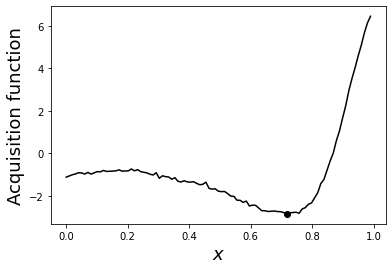

6/12


sample: 100%|██████████| 4000/4000 [00:07<00:00, 511.67it/s, 31 steps of size 1.56e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.39      0.30      0.31      0.04      0.75    811.64      1.00
          a      3.43      0.83      3.44      2.10      4.82    750.14      1.00
          b      7.70      0.49      7.68      6.92      8.51   1035.58      1.00
k_length[0]      1.44      1.96      0.81      0.03      3.24   1499.35      1.00
    k_scale      1.46      1.88      0.86      0.06      3.29    523.78      1.00
      noise      3.53      2.26      3.02      0.28      6.35    616.77      1.00

Number of divergences: 0


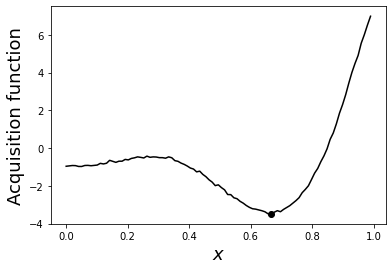

7/12


sample: 100%|██████████| 4000/4000 [00:08<00:00, 452.24it/s, 127 steps of size 3.56e-02. acc. prob=0.98]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.39      0.33      0.31      0.04      0.75    636.81      1.00
          a      3.42      0.84      3.43      2.20      4.94    694.33      1.00
          b     13.82      2.23     14.16     13.40     15.04     35.97      1.03
k_length[0]      1.43      2.20      0.79      0.02      3.20   1092.66      1.00
    k_scale      1.58      2.07      0.89      0.05      3.64    562.82      1.00
      noise      2.68      1.78      2.26      0.41      4.92    744.93      1.00

Number of divergences: 0


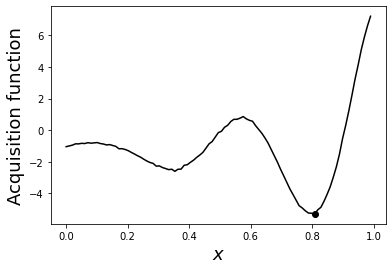

8/12


sample: 100%|██████████| 4000/4000 [00:08<00:00, 494.06it/s, 31 steps of size 1.38e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.33      0.27      0.25      0.03      0.63    961.57      1.00
          a      3.62      0.91      3.63      2.12      5.13    854.72      1.00
          b      7.38      0.40      7.35      6.71      8.01    857.19      1.00
k_length[0]      1.26      1.84      0.66      0.03      2.95    972.39      1.00
    k_scale      1.84      2.27      1.06      0.05      4.34    618.19      1.00
      noise      3.20      2.10      2.75      0.21      5.83    559.77      1.00

Number of divergences: 0


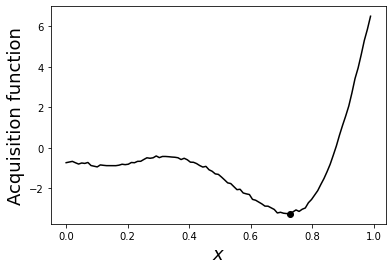

9/12


sample: 100%|██████████| 4000/4000 [00:08<00:00, 483.20it/s, 31 steps of size 1.10e-01. acc. prob=0.95] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.33      0.33      0.24      0.02      0.64    709.95      1.00
          a      3.67      0.99      3.72      2.20      5.26    432.31      1.00
          b      7.32      0.43      7.30      6.74      7.95    608.10      1.00
k_length[0]      1.16      1.82      0.54      0.02      2.94    541.06      1.00
    k_scale      2.30      3.44      1.20      0.03      5.38    353.50      1.00
      noise      2.62      1.86      2.25      0.16      4.89    427.77      1.00

Number of divergences: 0


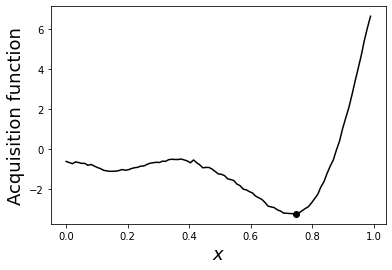

10/12


sample: 100%|██████████| 4000/4000 [00:08<00:00, 463.96it/s, 31 steps of size 1.17e-01. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.35      0.31      0.25      0.03      0.71    220.88      1.01
          a      3.66      0.97      3.71      2.21      5.26    350.43      1.00
          b      6.80      1.75      7.25      6.55      8.43     13.63      1.10
k_length[0]      0.89      1.56      0.24      0.03      2.39    504.91      1.00
    k_scale      3.36      4.56      1.72      0.05      8.20     80.81      1.02
      noise      2.00      1.70      1.64      0.17      4.06    265.69      1.02

Number of divergences: 5


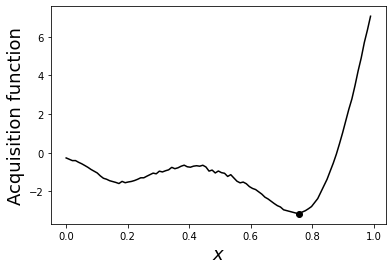

11/12


sample: 100%|██████████| 4000/4000 [00:08<00:00, 457.04it/s, 31 steps of size 1.15e-01. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.32      0.26      0.24      0.04      0.64    683.67      1.00
          a      3.75      0.94      3.80      2.40      5.32    443.98      1.00
          b      7.20      0.43      7.20      6.70      7.73    254.70      1.01
k_length[0]      1.18      1.65      0.63      0.03      2.82    848.13      1.00
    k_scale      1.91      2.69      1.00      0.03      4.32    368.84      1.00
      noise      2.79      1.60      2.48      0.49      4.71    623.15      1.01

Number of divergences: 1


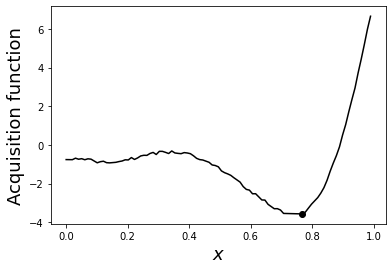

12/12


sample: 100%|██████████| 4000/4000 [00:09<00:00, 444.14it/s, 31 steps of size 1.14e-01. acc. prob=0.93] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.32      0.27      0.24      0.04      0.64    578.95      1.00
          a      3.80      0.94      3.83      2.40      5.44    495.01      1.00
          b      7.21      0.35      7.17      6.66      7.73    666.42      1.00
k_length[0]      1.01      1.53      0.42      0.03      2.61    688.94      1.00
    k_scale      2.49      3.39      1.39      0.07      5.82    526.26      1.00
      noise      2.32      1.45      2.05      0.42      4.15    479.81      1.00

Number of divergences: 0


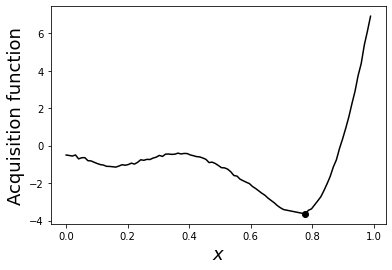

In [ ]:
exploration_steps = 12
acq_fn = UCB  #EI

rng_key, rng_key_predict = jra.split(jra.PRNGKey(0))

for e in range(exploration_steps):
    print("{}/{}".format(e+1, exploration_steps))
    # Initiate GP model
    gp_model = GP2(1, RBFKernel, mean_fn=oscfunc)
    # Get/update GP posterior
    gp_model.fit(rng_key, X_train, y_train, num_chains=1)
    # Compute acquisition 
    obj = acq_fn(rng_key_predict, gp_model, X_test)
    # Find maximum/minimum of acquisiton function to select the next "measurement" point
    next_point_idx = obj.argmax() if acq_fn == EI else obj.argmin()
    next_point = indices_test[next_point_idx]
    # Do "measurement"
    measured_point = y_test[next_point_idx]
    # Plot current result
    plot_result(X_test, obj, next_point_idx)
    # Append to the arrays of measured points
    X_train = jnp.append(X_train, X_test[next_point_idx][None], 0)
    X_test = jnp.delete(X_test, next_point_idx, 0)
    y_train = jnp.append(y_train, measured_point)
    y_test = jnp.delete(y_test, next_point_idx)
    indices_train = jnp.append(indices_train, next_point)
    indices_test = jnp.delete(indices_test, next_point_idx)

Plot results together with GP prediction on the final set of discovered points:

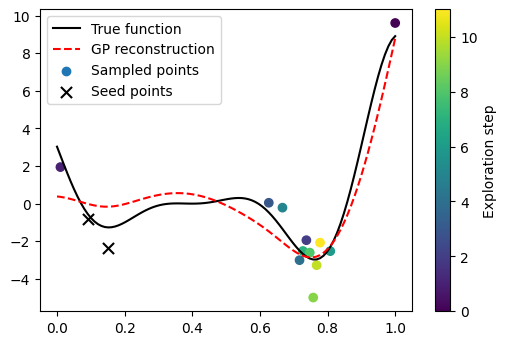

In [ ]:
y_pred, _ = gp_model.predict(rng_key_predict, X)

plot_final_result(X_train, y_train, y_pred)